# Semi-Supervised Learning Pipeline for Weld Quality Classification

## Overview
This notebook implements a complete semi-supervised learning (SSL) pipeline to classify weld quality from partially labeled data.

### Pipeline Steps:
1. **Data Loading**: Load pre-processed features (PCA or clean)
2. **Classification**: Convert continuous values to quality classes (Bad, Medium, Good) using tertiles
3. **SSL Training**: Train Label Propagation and Label Spreading models
4. **RF Training**: Train Random Forest classifiers on propagated labels
5. **Hyperparameter Tuning**: Optimize SSL and RF parameters (optional)
6. **Evaluation**: Compare models and visualize results
7. **Export**: Save predictions, metrics, and best parameters

### Key Features:
- Data-driven tertile classification (33.3% / 66.6% percentiles)
- Comprehensive hyperparameter tuning with grid search
- Model comparison and visualization
- Feature importance analysis
- Reproducible results with saved thresholds and parameters

In [58]:
# Imports 

import sys
sys.path.append('..')

# Data manipulation
import pandas as pd
import numpy as np
from pathlib import Path

# Semi-supervised learning
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

# Supervised learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Metrics and evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Custom loader
from semi_supervised.loader import load_data, TARGET_COLS

# Utilities
import warnings

print("===> All libraries imported successfully")

===> All libraries imported successfully


## 1. Configuration & Data Loading

In [59]:
# Configuration

# Target variable to predict (choose one)
TARGET_NAME = "yield_strength_MPa"  
# Options: yield_strength_MPa, uts_MPa, elongation_pct, 
#          reduction_area_pct, charpy_temp_C, charpy_toughness_J

# Feature set version
DATA_VERSION = "pca"  # Options: "pca" (PCA-reduced) or "clean" (all features)

# Hyperparameter tuning
ENABLE_TUNING = True  # Set to False to use default parameters (faster execution)

print(f"Configuration:")
print(f"  Target: {TARGET_NAME}")
print(f"  Features: {DATA_VERSION}")
print(f"  Tuning: {'Enabled' if ENABLE_TUNING else 'Disabled'}")

Configuration:
  Target: yield_strength_MPa
  Features: pca
  Tuning: Enabled


In [60]:
# Load data

# project root
project_root = Path.cwd().parent.parent if 'semi_supervised' in str(Path.cwd()) else Path.cwd()
base_path = project_root / "data" / "data_splits"

# Load train, validation, and test sets
train, val, test = load_data(TARGET_NAME, data_version=DATA_VERSION, base_path=str(base_path))

if train is None:
    raise ValueError("XXX Failed to load data. Check if files exist.")

# Unpack data
X_train, y_train = train
X_val, y_val = val
X_test, y_test = test

# Display data info
print(f"\n{'='*70}")
print(f"DATA LOADED: {TARGET_NAME} ({DATA_VERSION} features)")
print(f"{'='*70}")
print(f"Training set:   {X_train.shape[0]:4d} samples x {X_train.shape[1]:3d} features")
print(f"Validation set: {X_val.shape[0]:4d} samples x {X_val.shape[1]:3d} features")
print(f"Test set:       {X_test.shape[0]:4d} samples x {X_test.shape[1]:3d} features")
print(f"{'='*70}")

Loading PCA data for target: yield_strength_MPa
Data directory: c:\Users\Ouissal\weld-quality\data\data_splits\yield_strength_MPa
==> Data loaded successfully:
  Train: X=(1340, 19), y=(1340,)
  Val:   X=(156, 19), y=(156,)
  Test:  X=(156, 19), y=(156,)
  Features: 19
--> No missing values detected

DATA LOADED: yield_strength_MPa (pca features)
Training set:   1340 samples x  19 features
Validation set:  156 samples x  19 features
Test set:        156 samples x  19 features


## 2. Quality Classification (Continuous → Classes)

In [61]:
# Convert continuous values to quality classes

def convert_to_quality_classes_tertiles(y_train, y_val, y_test):
    """
    Convert continuous target values to quality classes using tertiles.
    
    Thresholds are computed ONLY from labeled training data to prevent data leakage.
    
    Classes:
        0: Bad quality    (< 33.3 percentile)
        1: Medium quality (33.3 - 66.6 percentile)
        2: Good quality   (> 66.6 percentile)
       -1: Unlabeled      (for semi-supervised learning)
    
    Args:
        y_train, y_val, y_test: Target Series (may contain NaN for unlabeled)
    
    Returns:
        Classified Series for train/val/test, and low/high thresholds
    """
    # Get labeled training data only
    labeled_y_train = y_train.dropna()
    
    if len(labeled_y_train) == 0:
        raise ValueError("XXX No labeled training data available!")
    
    # Compute tertile thresholds
    threshold_low = labeled_y_train.quantile(1/3)
    threshold_high = labeled_y_train.quantile(2/3)
    
    print(f"Tertile Thresholds (from {len(labeled_y_train)} labeled samples):")
    print(f"  Bad/Medium:   {threshold_low:.2f}")
    print(f"  Medium/Good:  {threshold_high:.2f}")
    
    def classify(y):
        """Apply classification to any dataset"""
        y_classes = pd.Series(index=y.index, dtype=int)
        unlabeled_mask = y.isna()
        
        # Classify labeled data
        y_classes[~unlabeled_mask & (y < threshold_low)] = 0
        y_classes[~unlabeled_mask & (y >= threshold_low) & (y < threshold_high)] = 1
        y_classes[~unlabeled_mask & (y >= threshold_high)] = 2
        
        # Mark unlabeled with -1
        y_classes[unlabeled_mask] = -1
        
        return y_classes
    
    return (classify(y_train), classify(y_val), classify(y_test), 
            threshold_low, threshold_high)


# Apply classification
print(f"\n{'='*70}")
print("CONVERTING TO QUALITY CLASSES")
print(f"{'='*70}")
print("Strategy: Data-driven tertiles (33.3% / 66.6% percentiles)\n")

y_train_classes, y_val_classes, y_test_classes, threshold_low, threshold_high = \
    convert_to_quality_classes_tertiles(y_train, y_val, y_test)

print(f"===> Classification complete ! ")


CONVERTING TO QUALITY CLASSES
Strategy: Data-driven tertiles (33.3% / 66.6% percentiles)

Tertile Thresholds (from 468 labeled samples):
  Bad/Medium:   463.67
  Medium/Good:  533.33
===> Classification complete ! 



CLASS DISTRIBUTION IN TRAINING DATA
  Bad (0):       156 samples (33.3%)
  Medium (1):    156 samples (33.3%)
  Good (2):      156 samples (33.3%)
  Unlabeled:     872 samples



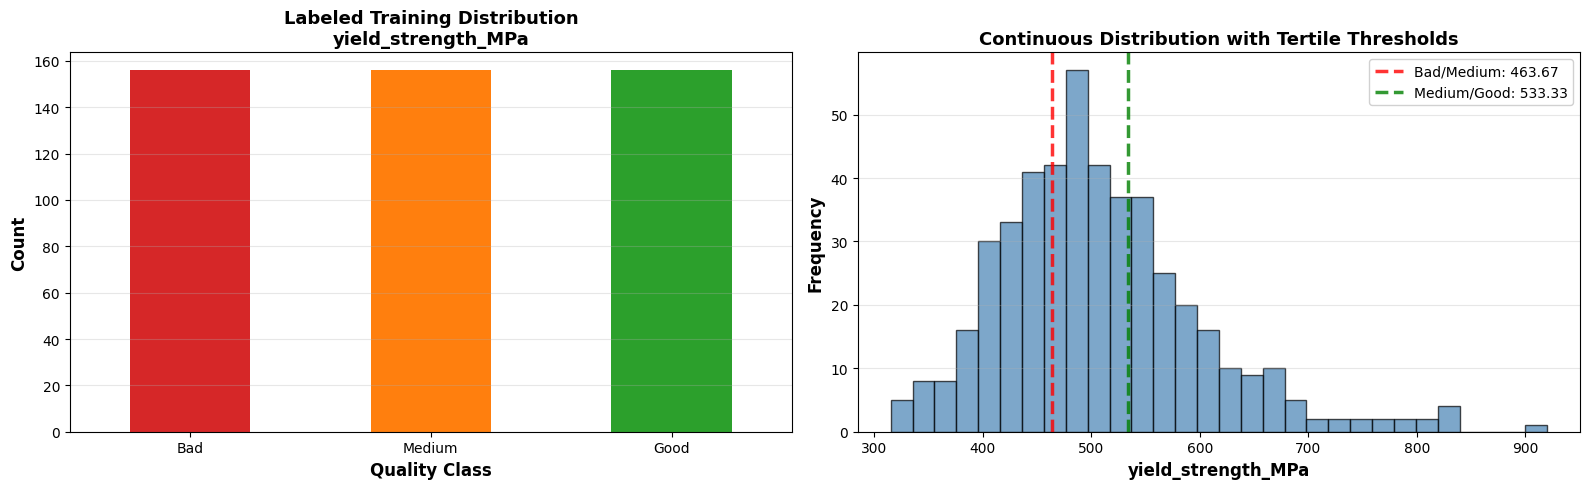

In [62]:
# Class distribution

# Calculate class distribution
labeled_mask = y_train_classes != -1
class_counts = y_train_classes[labeled_mask].value_counts().sort_index()

print(f"\n{'='*70}")
print("CLASS DISTRIBUTION IN TRAINING DATA")
print(f"{'='*70}")
print(f"  Bad (0):      {class_counts.get(0, 0):4d} samples ({class_counts.get(0, 0)/labeled_mask.sum()*100:.1f}%)")
print(f"  Medium (1):   {class_counts.get(1, 0):4d} samples ({class_counts.get(1, 0)/labeled_mask.sum()*100:.1f}%)")
print(f"  Good (2):     {class_counts.get(2, 0):4d} samples ({class_counts.get(2, 0)/labeled_mask.sum()*100:.1f}%)")
print(f"  Unlabeled:    {(y_train_classes == -1).sum():4d} samples")
print(f"{'='*70}\n")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: Bar chart of class distribution
class_counts.plot(kind='bar', ax=axes[0], color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[0].set_xlabel("Quality Class", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Count", fontsize=12, fontweight='bold')
axes[0].set_title(f"Labeled Training Distribution\n{TARGET_NAME}", fontsize=13, fontweight='bold')
axes[0].set_xticklabels(['Bad', 'Medium', 'Good'], rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

# Right: Histogram with tertile thresholds
labeled_y_train = y_train.dropna()
axes[1].hist(labeled_y_train, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(threshold_low, color='red', linestyle='--', linewidth=2.5, 
                label=f'Bad/Medium: {threshold_low:.2f}', alpha=0.8)
axes[1].axvline(threshold_high, color='green', linestyle='--', linewidth=2.5, 
                label=f'Medium/Good: {threshold_high:.2f}', alpha=0.8)
axes[1].set_xlabel(f"{TARGET_NAME}", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Frequency", fontsize=12, fontweight='bold')
axes[1].set_title(f"Continuous Distribution with Tertile Thresholds", fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10, framealpha=0.9)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. Hyperparameter Tuning Configuration

In [63]:
# Hyperparameters grid

# SSL parameter grids
ssl_param_grids = {
    "LabelPropagation": {
        'kernel': ['rbf', 'knn'],
        'gamma': [5, 10, 20, 30, 50],       # For RBF kernel
        'n_neighbors': [3, 5, 7, 10],       # For KNN kernel
        'max_iter': [2000]                  # Increased for better convergence
    },
    "LabelSpreading": {
        'kernel': ['rbf', 'knn'],
        'gamma': [5, 10, 20, 30, 50],       # For RBF kernel
        'alpha': [0.1, 0.2, 0.3, 0.5],      # Clamping factor
        'n_neighbors': [3, 5, 7, 10],       # For KNN kernel
        'max_iter': [2000]                  # Increased for better convergence
    }
}

# Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Display tuning configuration
print(f"{'='*70}")
print("HYPERPARAMETER TUNING CONFIGURATION")
print(f"{'='*70}")
print(f"Status: {'ENABLED' if ENABLE_TUNING else 'DISABLED'}\n")

if ENABLE_TUNING:
    print("SSL Parameter Grids:")
    for method, params in ssl_param_grids.items():
        n_combos = (len(params['gamma']) + len(params['n_neighbors'])) * params.get('alpha', [1])
        if 'alpha' in params:
            n_combos = len(params['gamma']) * len(params['alpha']) + len(params['n_neighbors']) * len(params['alpha'])
        else:
            n_combos = len(params['gamma']) + len(params['n_neighbors'])
        print(f"  - {method}: ~{n_combos} combinations")
    
    rf_combos = (len(rf_param_grid['n_estimators']) * len(rf_param_grid['max_depth']) * 
                 len(rf_param_grid['min_samples_split']) * len(rf_param_grid['min_samples_leaf']) * 
                 len(rf_param_grid['max_features']))
    print(f"  - Random Forest: 30 random samples from ~{rf_combos} combinations")
else:
    print("Using default parameters (fast mode)")

print(f"{'='*70}")

HYPERPARAMETER TUNING CONFIGURATION
Status: ENABLED

SSL Parameter Grids:
  - LabelPropagation: ~9 combinations
  - LabelSpreading: ~36 combinations
  - Random Forest: 30 random samples from ~216 combinations


In [64]:
# SSL hyperparameter tuning function

def tune_ssl_model(ModelClass, param_grid, X_train, y_train_classes, X_val, y_val_classes, method_name):
    """
    Tune SSL model hyperparameters using grid search with validation F1 score (weighted).
    
    Tests all combinations of parameters for both RBF and KNN kernels.
    Suppresses convergence warnings for cleaner output.
    """
    print(f"\n{'='*70}")
    print(f"TUNING {method_name}")
    print(f"{'='*70}")
    
    best_score = 0
    best_params = None
    best_model = None
    results = []
    
    # Suppress warnings for cleaner output
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', message='max_iter.*without convergence')
        
        for kernel in param_grid['kernel']:
            if kernel == 'rbf':
                # Test RBF kernel with gamma values
                for gamma in param_grid['gamma']:
                    params = {'kernel': kernel, 'gamma': gamma, 'max_iter': param_grid['max_iter'][0]}
                    
                    if 'alpha' in param_grid:  # LabelSpreading
                        for alpha in param_grid['alpha']:
                            params_with_alpha = {**params, 'alpha': alpha}
                            try:
                                model = ModelClass(**params_with_alpha, tol=1e-3)
                                model.fit(X_train, y_train_classes)
                                y_val_pred = model.predict(X_val)
                                score = f1_score(y_val_classes, y_val_pred, average='weighted')
                                
                                results.append({**params_with_alpha, 'val_f1_score': score})
                                if score > best_score:
                                    best_score, best_params, best_model = score, params_with_alpha, model
                            except Exception as e:
                                print(f"  [!]  Skipped {params_with_alpha}: {str(e)[:50]}")
                    else:  # LabelPropagation
                        try:
                            model = ModelClass(**params, tol=1e-3)
                            model.fit(X_train, y_train_classes)
                            y_val_pred = model.predict(X_val)
                            score = f1_score(y_val_classes, y_val_pred, average='weighted')
                            
                            results.append({**params, 'val_f1_score': score})
                            if score > best_score:
                                best_score, best_params, best_model = score, params, model
                        except Exception as e:
                            print(f"  [!]  Skipped {params}: {str(e)[:50]}")
            
            elif kernel == 'knn':
                # Test KNN kernel with n_neighbors values
                for n_neighbors in param_grid['n_neighbors']:
                    params = {'kernel': kernel, 'n_neighbors': n_neighbors, 'max_iter': param_grid['max_iter'][0]}
                    
                    if 'alpha' in param_grid:  # LabelSpreading
                        for alpha in param_grid['alpha']:
                            params_with_alpha = {**params, 'alpha': alpha}
                            try:
                                model = ModelClass(**params_with_alpha, tol=1e-3)
                                model.fit(X_train, y_train_classes)
                                y_val_pred = model.predict(X_val)
                                score = f1_score(y_val_classes, y_val_pred, average='weighted')
                                
                                results.append({**params_with_alpha, 'val_f1_score': score})
                                if score > best_score:
                                    best_score, best_params, best_model = score, params_with_alpha, model
                            except Exception as e:
                                print(f"  [!]  Skipped {params_with_alpha}: {str(e)[:50]}")
                    else:  # LabelPropagation
                        try:
                            model = ModelClass(**params, tol=1e-3)
                            model.fit(X_train, y_train_classes)
                            y_val_pred = model.predict(X_val)
                            score = f1_score(y_val_classes, y_val_pred, average='weighted')
                            
                            results.append({**params, 'val_f1_score': score})
                            if score > best_score:
                                best_score, best_params, best_model = score, params, model
                        except Exception as e:
                            print(f"  [!]  Skipped {params}: {str(e)[:50]}")
    
    # Display results
    results_df = pd.DataFrame(results).sort_values('val_f1_score', ascending=False)
    
    print(f"\n===> Tested {len(results)} parameter combinations")
    print(f"\nTop 3 configurations:")
    print(results_df.head(3).to_string(index=False))
    print(f"\n{'─'*70}")
    print(f"BEST: {best_params}")
    print(f"Validation F1 Score (weighted): {best_score*100:.2f}%")
    print(f"{'─'*70}")
    
    return best_model, best_params, best_score, results_df

## 4. Semi-Supervised Learning Training

In [65]:
# Train SSL models with and without tuning

if ENABLE_TUNING:
    print(f"\n{'='*70}")
    print("SSL HYPERPARAMETER TUNING")
    print(f"{'='*70}")
    print("Note: Convergence warnings are suppressed for cleaner output\n")
    
    tuning_results = {}
    best_ssl_models = {}
    best_ssl_params = {}
    
    # Tune LabelPropagation
    best_lp_model, best_lp_params, best_lp_score, lp_results = tune_ssl_model(
        LabelPropagation, ssl_param_grids['LabelPropagation'],
        X_train.values, y_train_classes.values, X_val.values, y_val_classes,
        "LabelPropagation"
    )
    best_ssl_models['LabelPropagation'] = best_lp_model
    best_ssl_params['LabelPropagation'] = best_lp_params
    tuning_results['LabelPropagation'] = lp_results
    
    # Tune LabelSpreading
    best_ls_model, best_ls_params, best_ls_score, ls_results = tune_ssl_model(
        LabelSpreading, ssl_param_grids['LabelSpreading'],
        X_train.values, y_train_classes.values, X_val.values, y_val_classes,
        "LabelSpreading"
    )
    best_ssl_models['LabelSpreading'] = best_ls_model
    best_ssl_params['LabelSpreading'] = best_ls_params
    tuning_results['LabelSpreading'] = ls_results
    
    print(f"\n{'='*70}")
    print("===> SSL TUNING COMPLETED")
    print(f"{'='*70}")
    
    ssl_models = best_ssl_models
    
else:
    # Use default parameters (fast mode)
    ssl_models = {
        "LabelPropagation": LabelPropagation(kernel='rbf', gamma=20, max_iter=1000, tol=1e-3),
        "LabelSpreading": LabelSpreading(kernel='rbf', gamma=20, alpha=0.2, max_iter=1000, tol=1e-3)
    }
    
    print(f"\n{'='*70}")
    print("USING DEFAULT SSL PARAMETERS")
    print(f"{'='*70}")
    print("LabelPropagation: kernel='rbf', gamma=20")
    print("LabelSpreading:   kernel='rbf', gamma=20, alpha=0.2")
    print(f"{'='*70}")


SSL HYPERPARAMETER TUNING
Note: Convergence warnings are suppressed for cleaner output


TUNING LabelPropagation

===> Tested 9 parameter combinations

Top 3 configurations:
kernel  gamma  max_iter  val_f1_score  n_neighbors
   rbf   30.0      2000      0.589303          NaN
   rbf   50.0      2000      0.589303          NaN
   knn    NaN      2000      0.587204          3.0

──────────────────────────────────────────────────────────────────────
BEST: {'kernel': 'rbf', 'gamma': 30, 'max_iter': 2000}
Validation F1 Score (weighted): 58.93%
──────────────────────────────────────────────────────────────────────

TUNING LabelSpreading

===> Tested 36 parameter combinations

Top 3 configurations:
kernel  gamma  max_iter  alpha  val_f1_score  n_neighbors
   rbf    5.0      2000    0.1      0.589793          NaN
   knn    NaN      2000    0.2      0.584627          3.0
   knn    NaN      2000    0.1      0.584627          3.0

──────────────────────────────────────────────────────────────────

In [66]:
# Train SSL models and propagate labels

print(f"\n{'='*70}")
print("TRAINING SEMI-SUPERVISED MODELS")
print(f"{'='*70}\n")

predictions = {}
trained_models = {}

for method_name, model in ssl_models.items():
    print(f"[{method_name}]")
    print(f"  Training on {len(y_train_classes)} samples...")
    print(f"    - Labeled:   {(y_train_classes != -1).sum():4d}")
    print(f"    - Unlabeled: {(y_train_classes == -1).sum():4d}")
    
    # Train SSL model
    model.fit(X_train.values, y_train_classes.values)
    
    # Get propagated labels
    y_train_propagated = model.transduction_
    
    # Predict on validation and test sets
    y_val_pred = model.predict(X_val.values)
    y_test_pred = model.predict(X_test.values)
    
    # Store results
    predictions[method_name] = {
        'train': y_train_propagated,
        'val': y_val_pred,
        'test': y_test_pred
    }
    trained_models[method_name] = model
    
    # Evaluate with both accuracy and F1 score
    val_accuracy = accuracy_score(y_val_classes, y_val_pred)
    val_f1 = f1_score(y_val_classes, y_val_pred, average='weighted')
    print(f"  ===> Training completed")
    print(f"  ===> Validation Accuracy: {val_accuracy*100:.2f}%")
    print(f"  ===> Validation F1 Score: {val_f1*100:.2f}%\n")

print(f"{'='*70}")
print("===> ALL SSL MODELS TRAINED !")
print(f"{'='*70}")


TRAINING SEMI-SUPERVISED MODELS

[LabelPropagation]
  Training on 1340 samples...
    - Labeled:    468
    - Unlabeled:  872
  ===> Training completed
  ===> Validation Accuracy: 60.26%
  ===> Validation F1 Score: 58.93%

[LabelSpreading]
  Training on 1340 samples...
    - Labeled:    468
    - Unlabeled:  872
  ===> Training completed
  ===> Validation Accuracy: 60.90%
  ===> Validation F1 Score: 58.98%

===> ALL SSL MODELS TRAINED !


C:\Users\Ouissal\AppData\Roaming\Python\Python312\site-packages\sklearn\semi_supervised\_label_propagation.py:322: ConvergenceWarning: max_iter=2000 was reached without convergence.
  warnings.warn(
C:\Users\Ouissal\AppData\Roaming\Python\Python312\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\Ouissal\AppData\Roaming\Python\Python312\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\Ouissal\AppData\Roaming\Python\Python312\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


## 5. Random Forest Training on Propagated Labels

In [67]:
# Train random forest with propagated label using default params

print(f"\n{'='*70}")
print("TRAINING RANDOM FOREST CLASSIFIERS")
print(f"{'='*70}\n")

rf_models = {}
rf_predictions = {}

for ssl_method in ssl_models.keys():
    print(f"[RF + {ssl_method}]")
    
    # Use propagated labels from SSL
    y_train_ssl = predictions[ssl_method]['train']
    
    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    print(f"  Training on {len(y_train_ssl)} samples (all with propagated labels)...")
    rf.fit(X_train.values, y_train_ssl)
    
    # Predict
    y_val_pred_rf = rf.predict(X_val.values)
    y_test_pred_rf = rf.predict(X_test.values)
    
    # Store
    rf_models[ssl_method] = rf
    rf_predictions[ssl_method] = {
        'val': y_val_pred_rf,
        'test': y_test_pred_rf
    }
    
    # Evaluate with both accuracy and F1 score
    val_accuracy_rf = accuracy_score(y_val_classes, y_val_pred_rf)
    val_f1_rf = f1_score(y_val_classes, y_val_pred_rf, average='weighted')
    print(f"  ===> Training completed")
    print(f"  ===> Validation Accuracy: {val_accuracy_rf*100:.2f}%")
    print(f"  ===> Validation F1 Score: {val_f1_rf*100:.2f}%\n")

print(f"{'='*70}")
print("===> ALL RANDOM FOREST MODELS TRAINED")
print(f"{'='*70}")


TRAINING RANDOM FOREST CLASSIFIERS

[RF + LabelPropagation]
  Training on 1340 samples (all with propagated labels)...
  ===> Training completed
  ===> Validation Accuracy: 62.82%
  ===> Validation F1 Score: 61.65%

[RF + LabelSpreading]
  Training on 1340 samples (all with propagated labels)...
  ===> Training completed
  ===> Validation Accuracy: 61.54%
  ===> Validation F1 Score: 60.14%

===> ALL RANDOM FOREST MODELS TRAINED


In [68]:
# RF hyperparameters tuning function

def tune_random_forest(X_train, y_train, X_val, y_val, param_grid, ssl_method_name, n_iter=30):
    """
    Tune Random Forest hyperparameters using RandomizedSearchCV with F1 score (weighted).
    
    Uses 3-fold cross-validation and tests n_iter random combinations.
    """
    print(f"\n{'='*70}")
    print(f"TUNING RF (trained on {ssl_method_name} labels)")
    print(f"{'='*70}")
    
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    random_search = RandomizedSearchCV(
        rf, param_distributions=param_grid, n_iter=n_iter, cv=3,
        scoring='f1_weighted', random_state=42, n_jobs=-1, verbose=0
    )
    
    print(f"Running RandomizedSearchCV ({n_iter} iterations, 3-fold CV)...")
    print(f"Scoring: F1 Score (weighted)")
    random_search.fit(X_train, y_train)
    
    # Evaluate on validation set
    best_rf = random_search.best_estimator_
    y_val_pred = best_rf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    print(f"\n===> Tuning completed !")
    print(f"\nBest parameters: {random_search.best_params_}")
    print(f"Best CV F1 score: {random_search.best_score_*100:.2f}%")
    print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
    print(f"Validation F1 Score: {val_f1*100:.2f}%")
    
    return best_rf, random_search.best_params_, val_f1, pd.DataFrame(random_search.cv_results_)


# Tune RF models if tuning enabled
if ENABLE_TUNING:
    print(f"\n{'='*70}")
    print("RF HYPERPARAMETER TUNING")
    print(f"{'='*70}")
    
    best_rf_models = {}
    best_rf_params = {}
    rf_tuning_results = {}
    
    for ssl_method in ssl_models.keys():
        y_train_ssl = predictions[ssl_method]['train']
        
        best_rf, best_params, val_score, rf_results = tune_random_forest(
            X_train.values, y_train_ssl, X_val.values, y_val_classes,
            rf_param_grid, ssl_method, n_iter=30
        )
        
        best_rf_models[ssl_method] = best_rf
        best_rf_params[ssl_method] = best_params
        rf_tuning_results[ssl_method] = rf_results
    
    print(f"\n{'='*70}")
    print("===> RF TUNING COMPLETED")
    print(f"{'='*70}")
    
    # Use tuned models
    rf_models = best_rf_models
    
    # Re-predict with tuned models
    rf_predictions = {}
    for ssl_method, rf_model in rf_models.items():
        rf_predictions[ssl_method] = {
            'val': rf_model.predict(X_val.values),
            'test': rf_model.predict(X_test.values)
        }
else:
    print(f"\n{'='*70}")
    print("SKIPPING RF TUNING")
    print(f"{'='*70}")
    print("Using default parameters from previous cell")
    print(f"{'='*70}")


RF HYPERPARAMETER TUNING

TUNING RF (trained on LabelPropagation labels)
Running RandomizedSearchCV (30 iterations, 3-fold CV)...
Scoring: F1 Score (weighted)

===> Tuning completed !

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best CV F1 score: 85.05%
Validation Accuracy: 61.54%
Validation F1 Score: 60.58%

TUNING RF (trained on LabelSpreading labels)
Running RandomizedSearchCV (30 iterations, 3-fold CV)...
Scoring: F1 Score (weighted)

===> Tuning completed !

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best CV F1 score: 84.99%
Validation Accuracy: 62.18%
Validation F1 Score: 61.08%

===> RF TUNING COMPLETED


## 6. Model Evaluation & Comparison

In [69]:
# Model comparaison summary

print(f"\n{'='*70}")
print("MODEL EVALUATION SUMMARY")
print(f"{'='*70}\n")

results = []

# Evaluate SSL models
for method_name in ssl_models.keys():
    val_acc = accuracy_score(y_val_classes, predictions[method_name]['val'])
    val_f1 = f1_score(y_val_classes, predictions[method_name]['val'], average='weighted')
    test_acc = accuracy_score(y_test_classes, predictions[method_name]['test'])
    test_f1 = f1_score(y_test_classes, predictions[method_name]['test'], average='weighted')
    
    results.append({
        'Model': method_name,
        'Val Accuracy': f"{val_acc*100:.2f}%",
        'Val F1': f"{val_f1*100:.2f}%",
        'Test Accuracy': f"{test_acc*100:.2f}%",
        'Test F1': f"{test_f1*100:.2f}%"
    })

# Evaluate RF models
for method_name in rf_models.keys():
    val_acc = accuracy_score(y_val_classes, rf_predictions[method_name]['val'])
    val_f1 = f1_score(y_val_classes, rf_predictions[method_name]['val'], average='weighted')
    test_acc = accuracy_score(y_test_classes, rf_predictions[method_name]['test'])
    test_f1 = f1_score(y_test_classes, rf_predictions[method_name]['test'], average='weighted')
    
    results.append({
        'Model': f"RF + {method_name}",
        'Val Accuracy': f"{val_acc*100:.2f}%",
        'Val F1': f"{val_f1*100:.2f}%",
        'Test Accuracy': f"{test_acc*100:.2f}%",
        'Test F1': f"{test_f1*100:.2f}%"
    })

# Display results table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print(f"\n{'='*70}")


MODEL EVALUATION SUMMARY

                Model Val Accuracy Val F1 Test Accuracy Test F1
     LabelPropagation       60.26% 58.93%        68.59%  68.47%
       LabelSpreading       60.90% 58.98%        68.59%  68.47%
RF + LabelPropagation       61.54% 60.58%        67.31%  66.84%
  RF + LabelSpreading       62.18% 61.08%        68.59%  68.37%




DETAILED EVALUATION: BEST MODELS (by F1 Score)
Best SSL: LabelSpreading
Best RF:  RF + LabelSpreading

──────────────────────────────────────────────────────────────────────
BEST SSL MODEL: LabelSpreading
──────────────────────────────────────────────────────────────────────

Test Accuracy: 68.59%
Test F1 Score: 68.47%

Classification Report:
              precision    recall  f1-score   support

         Bad       0.59      0.81      0.69        43
      Medium       0.72      0.58      0.64        59
        Good       0.76      0.70      0.73        54

    accuracy                           0.69       156
   macro avg       0.69      0.70      0.69       156
weighted avg       0.70      0.69      0.68       156



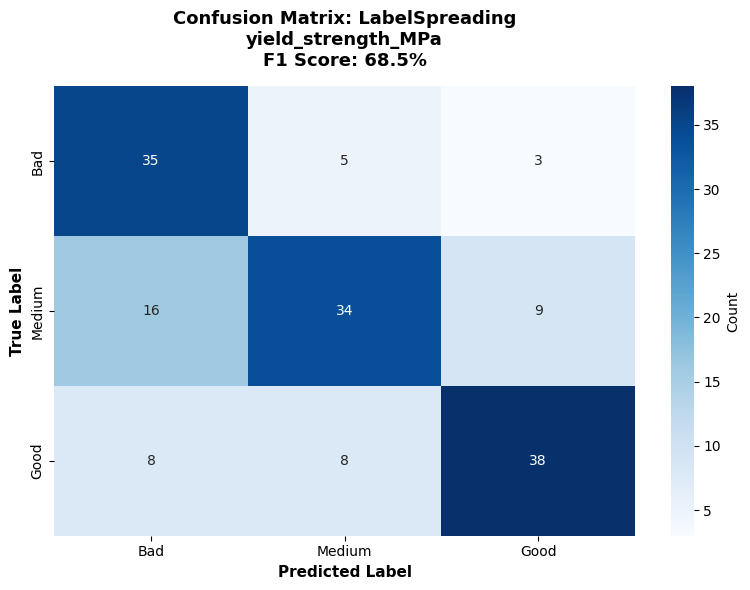


──────────────────────────────────────────────────────────────────────
BEST RF MODEL: RF + LabelSpreading
──────────────────────────────────────────────────────────────────────

Test Accuracy: 68.59%
Test F1 Score: 68.37%

Classification Report:
              precision    recall  f1-score   support

         Bad       0.63      0.79      0.70        43
      Medium       0.69      0.58      0.63        59
        Good       0.74      0.72      0.73        54

    accuracy                           0.69       156
   macro avg       0.69      0.70      0.69       156
weighted avg       0.69      0.69      0.68       156



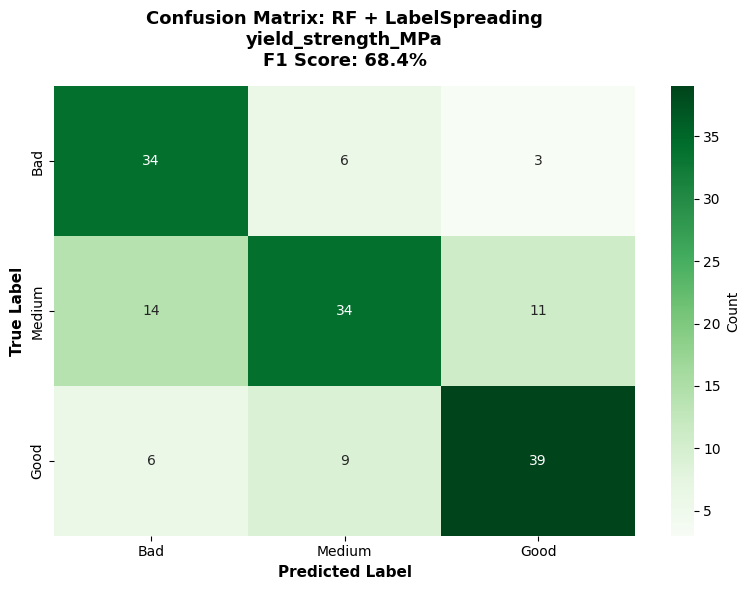


──────────────────────────────────────────────────────────────────────
TOP 10 FEATURE IMPORTANCES (RF + LabelSpreading)
──────────────────────────────────────────────────────────────────────
feature  importance
    PC3    0.074906
    PC9    0.073108
   PC13    0.073071
    PC6    0.065942
   PC14    0.062861
    PC4    0.054511
   PC10    0.053943
    PC1    0.053723
   PC17    0.051502
   PC16    0.051092


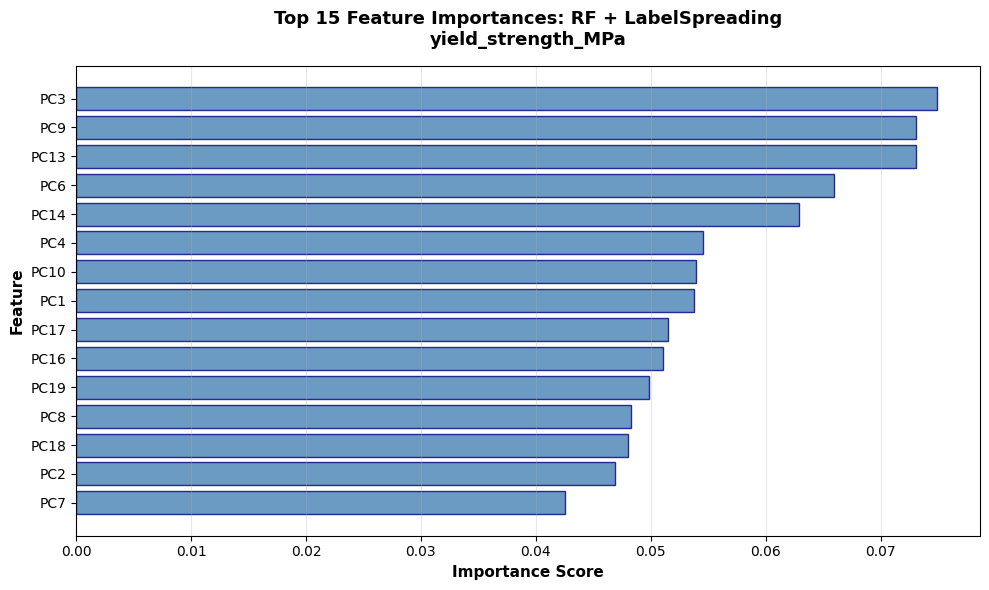

In [ ]:
# Detailed evaluation of best model

# Select best models based on validation F1 score (weighted)
best_ssl_method = max(ssl_models.keys(), 
                      key=lambda x: f1_score(y_val_classes, predictions[x]['val'], average='weighted'))
best_rf_method = max(rf_models.keys(), 
                     key=lambda x: f1_score(y_val_classes, rf_predictions[x]['val'], average='weighted'))

print(f"\n{'='*70}")
print("DETAILED EVALUATION: BEST MODELS (by F1 Score)")
print(f"{'='*70}")
print(f"Best SSL: {best_ssl_method}")
print(f"Best RF:  RF + {best_rf_method}")
print(f"{'='*70}\n")

# Best SSL model

print(f"{'─'*70}")
print(f"BEST SSL MODEL: {best_ssl_method}")
print(f"{'─'*70}\n")

y_test_pred_best_ssl = predictions[best_ssl_method]['test']
test_acc_ssl = accuracy_score(y_test_classes, y_test_pred_best_ssl)
test_f1_ssl = f1_score(y_test_classes, y_test_pred_best_ssl, average='weighted')

print(f"Test Accuracy: {test_acc_ssl*100:.2f}%")
print(f"Test F1 Score: {test_f1_ssl*100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test_classes, y_test_pred_best_ssl, 
                          target_names=['Bad', 'Medium', 'Good'], zero_division=0))

# Confusion matrix
cm_ssl = confusion_matrix(y_test_classes, y_test_pred_best_ssl)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ssl, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bad', 'Medium', 'Good'],
            yticklabels=['Bad', 'Medium', 'Good'], cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix: {best_ssl_method}\n{TARGET_NAME}\nF1 Score: {test_f1_ssl*100:.1f}%', 
          fontsize=13, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=11, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# Best RF model

print(f"\n{'─'*70}")
print(f"BEST RF MODEL: RF + {best_rf_method}")
print(f"{'─'*70}\n")

y_test_pred_best_rf = rf_predictions[best_rf_method]['test']
test_acc_rf = accuracy_score(y_test_classes, y_test_pred_best_rf)
test_f1_rf = f1_score(y_test_classes, y_test_pred_best_rf, average='weighted')

print(f"Test Accuracy: {test_acc_rf*100:.2f}%")
print(f"Test F1 Score: {test_f1_rf*100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test_classes, y_test_pred_best_rf, 
                          target_names=['Bad', 'Medium', 'Good'], zero_division=0))

# Confusion matrix
cm_rf = confusion_matrix(y_test_classes, y_test_pred_best_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Bad', 'Medium', 'Good'],
            yticklabels=['Bad', 'Medium', 'Good'], cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix: RF + {best_rf_method}\n{TARGET_NAME}\nF1 Score: {test_f1_rf*100:.1f}%', 
          fontsize=13, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=11, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance RF

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_models[best_rf_method].feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n{'─'*70}")
print(f"TOP 10 FEATURE IMPORTANCES (RF + {best_rf_method})")
print(f"{'─'*70}")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values, 
         color='steelblue', edgecolor='navy', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'].values, fontsize=10)
plt.xlabel('Importance Score', fontsize=11, fontweight='bold')
plt.ylabel('Feature', fontsize=11, fontweight='bold')
plt.title(f'Top 15 Feature Importances: RF + {best_rf_method}\n{TARGET_NAME}', 
          fontsize=13, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\n{'='*70}")

## 7. Export Results & Save Models

In [71]:
# save results to disk

# Create results directory
results_dir = project_root / "results" / "ssl_results" / TARGET_NAME
results_dir.mkdir(parents=True, exist_ok=True)

print(f"\n{'='*70}")
print("SAVING RESULTS")
print(f"{'='*70}\n")

# Save predictions for all models
for method_name in ssl_models.keys():
    # SSL predictions
    pd.DataFrame({
        'true': y_test_classes,
        'predicted': predictions[method_name]['test']
    }).to_csv(results_dir / f"{method_name}_predictions.csv", index=False)
    
    # RF predictions
    pd.DataFrame({
        'true': y_test_classes,
        'predicted': rf_predictions[method_name]['test']
    }).to_csv(results_dir / f"RF_{method_name}_predictions.csv", index=False)

print("===> Predictions saved !")

# Save model comparison table
results_df.to_csv(results_dir / "model_comparison.csv", index=False)
print("===> Model comparison saved !")

# Save feature importance (if using clean features)
if DATA_VERSION == "clean":
    feature_importance.to_csv(results_dir / "feature_importance.csv", index=False)
    print("===> Feature importance saved !")

# Save quality thresholds for reproducibility
pd.DataFrame({
    'threshold_type': ['Bad/Medium (33.3%)', 'Medium/Good (66.6%)'],
    'value': [threshold_low, threshold_high]
}).to_csv(results_dir / "quality_thresholds.csv", index=False)
print("===> Quality thresholds saved !")

print(f"\n{'─'*70}")
print(f"Results directory: {results_dir}")
print(f"{'─'*70}")
print(f"\n{'='*70}")
print("===> PIPELINE COMPLETED SUCCESSFULLY !")
print(f"{'='*70}")


SAVING RESULTS

===> Predictions saved !
===> Model comparison saved !
===> Quality thresholds saved !

──────────────────────────────────────────────────────────────────────
Results directory: c:\Users\Ouissal\weld-quality\results\ssl_results\yield_strength_MPa
──────────────────────────────────────────────────────────────────────

===> PIPELINE COMPLETED SUCCESSFULLY !


In [72]:
# Save hyperparameter tuning results if tuning was enabled

if ENABLE_TUNING:
    print(f"\n{'='*70}")
    print("SAVING HYPERPARAMETER TUNING RESULTS")
    print(f"{'='*70}\n")
    
    tuning_dir = results_dir / "tuning"
    tuning_dir.mkdir(exist_ok=True)
    
    # Save SSL tuning results
    for method_name, tuning_df in tuning_results.items():
        tuning_df.to_csv(tuning_dir / f"{method_name}_tuning_results.csv", index=False)
        print(f"===> {method_name} tuning results saved")
    
    # Save RF tuning results
    for method_name, tuning_df in rf_tuning_results.items():
        # Extract relevant columns
        cols = [col for col in tuning_df.columns 
                if any(x in col for x in ['param_', 'mean_test', 'std_test', 'rank_test'])]
        tuning_df[cols].to_csv(tuning_dir / f"RF_{method_name}_tuning_results.csv", index=False)
        print(f"===> RF + {method_name} tuning results saved")
    
    # Save best parameters
    ssl_params_df = pd.DataFrame([
        {'Method': method, **params} 
        for method, params in best_ssl_params.items()
    ])
    ssl_params_df.to_csv(tuning_dir / "best_ssl_parameters.csv", index=False)
    print("===> Best SSL parameters saved")
    
    rf_params_df = pd.DataFrame([
        {'SSL_Method': method, **params} 
        for method, params in best_rf_params.items()
    ])
    rf_params_df.to_csv(tuning_dir / "best_rf_parameters.csv", index=False)
    print("===> Best RF parameters saved")
    
    print(f"\n{'─'*70}")
    print(f"Tuning results directory: {tuning_dir}")
    print(f"{'─'*70}")
    print(f"\n{'='*70}")
    print("===> TUNING RESULTS SAVED")
    print(f"{'='*70}")
else:
    print(f"\n{'='*70}")
    print("TUNING DISABLED - No tuning results to save")
    print(f"{'='*70}")


SAVING HYPERPARAMETER TUNING RESULTS

===> LabelPropagation tuning results saved
===> LabelSpreading tuning results saved
===> RF + LabelPropagation tuning results saved
===> RF + LabelSpreading tuning results saved
===> Best SSL parameters saved
===> Best RF parameters saved

──────────────────────────────────────────────────────────────────────
Tuning results directory: c:\Users\Ouissal\weld-quality\results\ssl_results\yield_strength_MPa\tuning
──────────────────────────────────────────────────────────────────────

===> TUNING RESULTS SAVED
